In [7]:
import numpy as np
from bayes_tec.datapack import DataPack
import pylab as plt


2018-12-09 23:23:18,688 $HOME=/home/albert
2018-12-09 23:23:18,689 CONFIGDIR=/home/albert/.config/matplotlib
2018-12-09 23:23:18,690 matplotlib data path: /home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib/mpl-data
2018-12-09 23:23:18,693 loaded rc file /home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc
2018-12-09 23:23:18,694 matplotlib version 3.0.2
2018-12-09 23:23:18,695 interactive is False
2018-12-09 23:23:18,695 platform is linux
2018-12-09 23:23:18,696 loaded modules: ['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'site', 'os', 'errno', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'sysconf

2018-12-09 23:23:18,732 CACHEDIR=/home/albert/.cache/matplotlib
2018-12-09 23:23:18,734 Using fontManager instance from /home/albert/.cache/matplotlib/fontlist-v300.json
2018-12-09 23:23:18,802 Loaded backend module://ipykernel.pylab.backend_inline version unknown.
2018-12-09 23:23:18,805 Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [229]:
with DataPack('../../scripts/data/DR2_full_smoothed.h5',readonly=True) as datapack:
    datapack.select(pol=slice(0,1,1),ant='RS210HBA', time=None,freq=None)
    phase,axes = datapack.phase
    patch_names, directions = datapack.get_sources(axes['dir'])
    _,freqs = datapack.get_freqs(axes['freq'])
    

2018-12-11 14:31:53,275 Reading from /home/albert/git/bayes_tec/scripts/data/DR2_full_smoothed.h5.
2018-12-11 14:31:53,318 Closing table.


In [230]:
X_d = np.array([directions.ra.deg-directions.ra.deg.mean(), directions.dec.deg-directions.dec.deg.mean()]).T
dist = np.linalg.norm(X_d,axis=1)
Nd = dist.size
print(np.argmin((freqs-150e6)**2))

15


In [246]:
def wrap(phi):
    return np.angle(np.exp(1j*phi))
dphi = wrap(wrap(phase[...,1:]) - wrap(phase[...,0:-1]))

def flag_facets(phase, X_d):
    """
    :param phase: array (Npol, Nd, Na, Nf, Nt)
    :param X_d: array (Nd,2)
    """
    from scipy.stats import linregress
    def wrap(phi):
        return np.angle(np.exp(1j*phi))
    
    Npol, Nd, Na, Nf, Nt = phase.shape
    #Nd
    dist = np.linalg.norm(X_d,axis=1)
    #Npol, Nd, Na, Nf
    m = np.mean(wrap(wrap(phase[...,1:]) - wrap(phase[...,0:-1]))**2,axis=-1)
    flags = np.zeros([Nd,Na,Nf])
    for i in range(Na):
        for l in range(Nf):
            y = m[0,:,i,l]
            s, yint, _,_,_ = linregress(dist, y)
            if s==0:
                continue
            # remove 5 sigma points
            y_pred = yint + s*dist
            std = np.sqrt(np.mean((y-y_pred)**2))
            
            flag = np.where(np.abs(y-y_pred)/std > 5)[0]
            if len(flag) != 0:
                flags[flag,i,l] = 1
            select = ~np.isin(np.arange(Nd),flag)
            s, yint, _,_,_ = linregress(dist[select], y[select])
            # remove 5 sigma points
            y_pred = yint + s*dist
            std = np.sqrt(np.mean((y[select]-y_pred[select])**2))
            flag = np.where(np.abs(y-y_pred)/std > 3.5)[0]
            if len(flag) != 0:
                flags[flag,i,l] = 1
            
    return flags

flags = flag_facets(phase,X_d)

In [247]:
np.where(flags[:,0,:])[0]

array([24, 24, 24, 24, 24, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 38, 38, 38, 38, 38, 38,
       38, 38, 38, 38, 38, 38, 38])

2018-12-11 14:34:54,511 update_title_pos
2018-12-11 14:34:54,554 update_title_pos
2018-12-11 14:34:54,582 update_title_pos
2018-12-11 14:34:54,597 update_title_pos


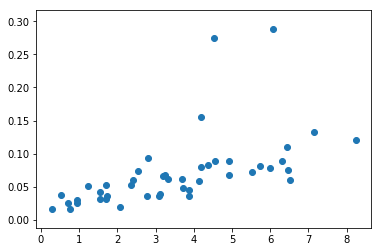

2018-12-11 14:34:54,653 update_title_pos
2018-12-11 14:34:54,695 update_title_pos
2018-12-11 14:34:54,723 update_title_pos
2018-12-11 14:34:54,739 update_title_pos


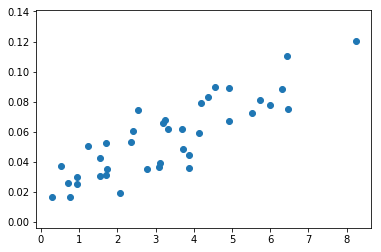

2018-12-11 14:34:54,806 update_title_pos
2018-12-11 14:34:54,846 update_title_pos
2018-12-11 14:34:54,874 update_title_pos
2018-12-11 14:34:54,889 update_title_pos


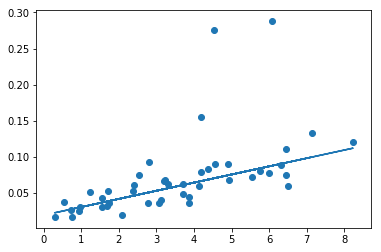

In [241]:
m = (dphi[0,:,0,0,:]**2).mean(-1)
plt.scatter(dist,m)
plt.show()

select = ~np.isin(np.arange(Nd),[ 1, 24, 29, 34, 36, 38])

plt.scatter(dist[select],m[select])
plt.show()

from scipy.stats import linregress

slope, yint, r,p,serr = linregress(dist[select],m[select])

m_pred = yint + slope*dist

std = np.mean((m-m_pred)**2)

plt.plot(dist,m_pred)
plt.scatter(dist,m)
plt.show()

In [242]:
# def flag_facets(phase, X_d):

std = np.sqrt(np.mean((m[select]-m_pred[select])**2))



np.where(np.abs(m-m_pred)>2*std)

(array([ 1, 12, 22, 24, 29, 34, 36, 38]),)

2018-12-11 14:34:59,698 update_title_pos
2018-12-11 14:34:59,741 update_title_pos
2018-12-11 14:34:59,769 update_title_pos
2018-12-11 14:34:59,785 update_title_pos


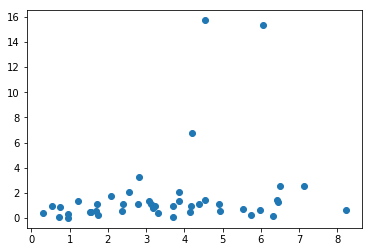

In [243]:
plt.scatter(dist,np.abs(m-m_pred)/std)
plt.show()

In [244]:
np.percentile(np.abs(m[select]-m_pred[select])/std,90)

1.433498508810284

In [245]:
np.sort(dist)

array([0.28873166, 0.5271993 , 0.7118962 , 0.7498338 , 0.9443598 ,
       0.954707  , 1.2284341 , 1.5414045 , 1.5570983 , 1.6931721 ,
       1.7042673 , 1.7396845 , 2.0793903 , 2.3692715 , 2.3961463 ,
       2.5399513 , 2.7877855 , 2.8089266 , 3.0772882 , 3.1169026 ,
       3.190232  , 3.2344644 , 3.3144588 , 3.699603  , 3.7140698 ,
       3.8652017 , 3.8656433 , 4.138897  , 4.1821475 , 4.1992574 ,
       4.3782926 , 4.530665  , 4.5493026 , 4.9144287 , 4.9303355 ,
       5.5343447 , 5.745291  , 5.9849887 , 6.0681148 , 6.313753  ,
       6.438177  , 6.459817  , 6.5146317 , 7.135495  , 8.237327  ],
      dtype=float32)